In [1]:
#basic package
import tqdm
import os
import numpy as np
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import math
import random
import scipy
from scipy import stats

#graph
import geopy.distance #compute dsitance between two lat,long
import uuid #add unique id, independantly of the order of the dataframe
import networkx as nx #construct graph not efficiently but userfriendly
import networkit as nk #more efficient
import pickle #save dico
#kdtree
from scipy.sparse import csr_matrix, load_npz, save_npz
from scipy.sparse.csgraph import connected_components
from scipy.spatial import KDTree
from scipy.sparse.csgraph import dijkstra
#from astropy.coordinates import EarthLocation  #transform ongitude, latitude into 3D cartesian space
import distinctiveness
from distinctiveness.dc import distinctiveness

#plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap #2Dmap
import seaborn as sns

In [2]:
import pyproj as ppj

In [3]:
#import cartopy
#!pip install cartopy

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
import config_origins as config

In [4]:
path = r'C:\Users\camil\Desktop\animals_code\ConnectivityAndProductivity'
name = 'FullSubnetwork5000final'
nbr_2add2mmax = 300*2 #from 0_Dataprocessing
m_max = 5000
#create a director if not existing
path_visual = os.path.join(path, 'Visuals')
if not os.path.exists(path_visual):
    os.makedirs(path_visual)

In [31]:
import random
dim_time = 15*60
nbr_mlp = 90000
li_mlp = []
for i in range(0,nbr_mlp):
    li_mlp.append([random.randrange(1, 10) for _ in range(0, dim_time)])
print(len(li_mlp))

90000


In [9]:
%%time
import random
dim_time = 15 #every hour 5 zones
nbr_mlp = 90000 #10000
li_mlp = []
for i in range(0,nbr_mlp):
    li_mlp.append([random.randrange(0,60) for _ in range(0, dim_time)])
print(len(li_mlp))
tree = scipy.spatial.KDTree(np.array(li_mlp))
#m1 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix")
pairs = tree.query_pairs(50, output_type="ndarray") #10600 have 5 times more nodes than 5000
print(pairs.shape)

90000
(1719628860, 2)
CPU times: total: 1min 20s
Wall time: 1min 36s


In [13]:
pairs[0]

array([ 4857, 28118], dtype=int64)

In [14]:
li_mlp[4857]

[6, 1, 0, 3, 2]

In [15]:
li_mlp[28118]

[3, 3, 7, 9, 0]

In [12]:
print(pairs.shape)

(1719628860, 2)


In [ ]:
%%time
#THIS ONE
import random
dim_time = 15*60 #every hour 5 zones
nbr_mlp = 100000
li_mlp = []
for i in range(0,nbr_mlp):
    li_mlp.append([random.randrange(0,1) for _ in range(0, dim_time)])
print(len(li_mlp))
tree = scipy.spatial.KDTree(np.array(li_mlp))
#m1 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix",p=2)
pairs = tree.query_pairs(np.sqrt(180), output_type="ndarray") #at least 3h in commun
#print(pairs.shape)
print(len(pairs))

100000


In [5]:
15*60

900

In [ ]:
%%time
m2 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix")
m3 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix")
m4 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix")
m5 = tree.sparse_distance_matrix(tree, 100, output_type="coo_matrix")

In [8]:
np.array([[1,2,3],[2,2,2],[133,1,1],[122,2,2],[3,3,3]])

array([[  1,   2,   3],
       [  2,   2,   2],
       [133,   1,   1],
       [122,   2,   2],
       [  3,   3,   3]])

# two different ways to represent the graph

In [5]:
%%time
# Download processed data & select subset
#df_USNetwork
df = pd.read_csv(os.path.join(path,'df_FullSubnetwork.csv'), sep=';')
df['geodesic_coordinates1'] = df['geodesic_coordinates1'].map(lambda x: eval(x))
display(df.head(3))
df.shape

,Centroid_lat,Centroid_lon,Area_sumInSqM,NPP_perArea,GPP_perArea,COVARIATE_MODE_Resolve_Biome,NDVI_mean_mean,ID,geodesic_coordinates1,Correct4Area
0,37.743207,-109.999837,437158.284058,0.505567,0.877498,13,0.232344,37-74320716783216_-109-99983688811176,"[-1727163.1812004019, -4745383.873641647, 3882...",373.030565
1,37.727527,-109.993852,270299.583679,0.515425,0.890279,13,0.236456,37-72752658371042_-109-9938518099548,"[-1727031.6703906644, -4746565.226514977, 3881...",293.324108
2,37.721877,-109.998747,451960.116150,0.516146,0.895811,13,0.224857,37-72187736806498_-109-9987467861976,"[-1727568.3875628256, -4746778.178527099, 3881...",379.293260


Wall time: 14.4 s


(1004178, 10)

In [54]:
df[df['Area_sumInSqM']>=250000].shape

(8940, 10)

In [50]:
#choose subgraph
lomid = -108.8
lamid = 39.9
d_ = 0.15
#select subdataset so that most data lie in a "natural" sub graph
df_ = df[(df['Centroid_lon']<= lomid+d_)&(df['Centroid_lon']>= lomid-d_)&\
         (df['Centroid_lat']<= lamid+d_)&(df['Centroid_lat']>= lamid-d_)].copy()
print(df_.shape)
coordinates = df_[["Centroid_lon", "Centroid_lat"]].values

(2506, 10)


# Based on triangulation

In [ ]:
#or plot with delaunay_plot_2d:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.delaunay_plot_2d.html#scipy.spatial.delaunay_plot_2d
#maybe compare with other triangulisation:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.SphericalVoronoi.html

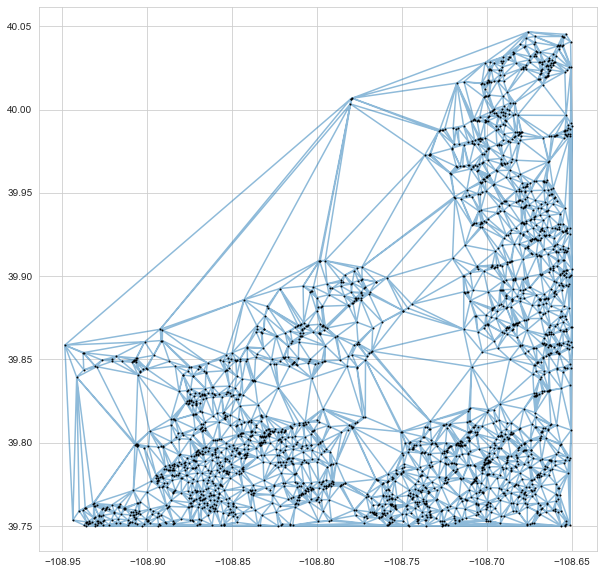

14988
7494
There is 4989 triangles and 7494 edges
7494
137304
there is 7204 chosen edges and 2506 nodes


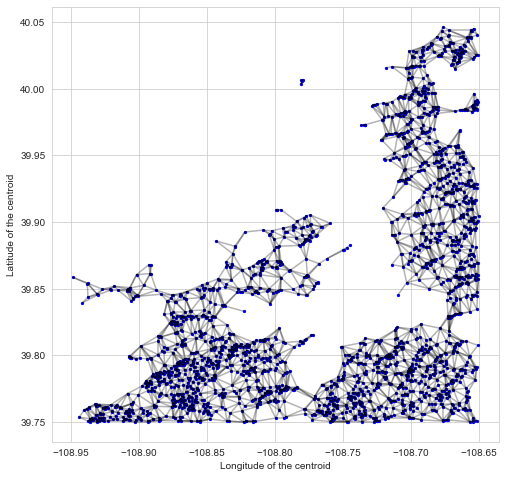

In [63]:
#find all triangles
triangulation = scipy.spatial.Delaunay(coordinates) 
#Note: if we use above the geodesic coordiantes we would en up with rectangles instead of triangles. 
#I think its correct to use coordiantes(lon,lat) instead, as triangulisation dont care about distance, it just need to know
#their order in the plane

#plot
plt.figure(figsize=(10,10))
plt.triplot(coordinates[:,0], coordinates[:,1], triangulation.simplices, alpha=0.5);
plt.scatter(coordinates[:,0], coordinates[:,1], color='black', s=1);
plt.savefig(os.path.join(path,'Illustration_triangulation.png'), bbox_inches='tight')
plt.show()

#construct pairs of patches that are connected through a triangle
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html:
#triangulation.vertex_neighbor_vertices: tuple of two ndarrays of int; (indptr, indices). The indices of neighboring vertices 
#of vertex k are indices[indptr[k]:indptr[k+1]].
indptr, indices = triangulation.vertex_neighbor_vertices
nodeid_pairs = []
for k in range(0,len(coordinates)):
    li = indices[indptr[k]:indptr[k+1]]
    nodeid_pairs.extend([tuple(sorted([k,i])) for i in li])
print(len(nodeid_pairs))
nodeid_pairs = list(set(nodeid_pairs)) 
print(len(nodeid_pairs))
nodeid_pairs = np.array([np.array(i) for i in nodeid_pairs])
print('There is %d triangles and %d edges' %(len(triangulation.simplices), len(nodeid_pairs)))


#with 3D cartesian for computing the distances
points = np.array(list(df_['geodesic_coordinates1']))
distances = []
size_ = 100000
m_ = len(pairs)
for i in range(0,m_,size_):
    pairs_ = nodeid_pairs[i:i+size_]
    differences_ = points[pairs_[:, 0]] - points[pairs_[:, 1]]
    distances_ = np.sqrt((differences_ ** 2).sum(axis=1))
    #round to the meters to save memory by using integers intead of floats
    distances_ = distances_.astype(int)
    distances = np.concatenate((distances, distances_), axis=0)
#add left over
pairs_ = nodeid_pairs[m_-(m_%3):]
differences_ = points[pairs_[:, 0]] - points[pairs_[:, 1]]
distances_ = np.sqrt((differences_ ** 2).sum(axis=1))
#round to the meters to save memory by using integers intead of floats
distances_ = distances_.astype(int)
distances = np.concatenate((distances, distances_), axis=0)
print(len(distances))
print(len(pairs))

#find remaining pairs 
pairs = []
for i,(n1,n2) in enumerate(nodeid_pairs):
    if distances[i]<=1500:
        pairs.append([[coordinates[n1][0], coordinates[n1][1]],[coordinates[n2][0], coordinates[n2][1]]])
pairs = np.array(pairs)
print('there is %d chosen edges and %d nodes'%(len(pairs),len(coordinates)))
#plot
plt.figure(figsize=(8,8))
plt.plot(pairs[:, :, 0].T, pairs[:, :, 1].T, c="black", alpha=0.3);
plt.scatter(coordinates[:,0], coordinates[:,1], color='blue', s=5);
plt.xlabel('Longitude of the centroid')
plt.ylabel('Latitude of the centroid');
plt.savefig(os.path.join(path,'Illustration_triangulationGraph1500.png'),  dpi=300, bbox_inches='tight')
plt.show();

# based solely on distances

(137304, 2, 2)


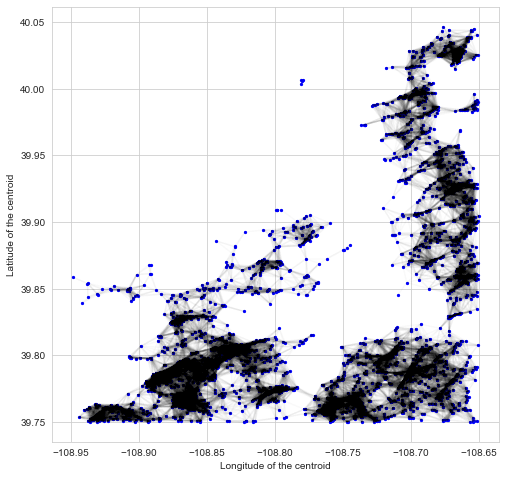

In [64]:
#select subdataset so that most data lie in a "natural" sub graph
points = np.array(list(df_['geodesic_coordinates1']))
tree = scipy.spatial.KDTree(points)
m = tree.sparse_distance_matrix(tree, 1500, output_type="coo_matrix")
m
indices = np.arange(len(df))
pairs = np.stack([
    coordinates[indices[m.row]],
    coordinates[indices[m.col]],], axis=1)
print(pairs.shape)

#plot
plt.figure(figsize=(8,8))
plt.plot(pairs[:, :, 0].T, pairs[:, :, 1].T, c="black", alpha=0.01);
plt.scatter(coordinates[:,0], coordinates[:,1], color='blue', s=5);
plt.xlabel('Longitude of the centroid')
plt.ylabel('Latitude of the centroid');
plt.savefig(os.path.join(path,'Illustration_distancegraph1500.png'), dpi=300, bbox_inches='tight')
plt.show();